In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np

In [2]:
IMG_DIM = 28
BATCH_SIZE = 100
LEARNING_RATE = 0.00002
LAYER_1 = 256
Z_SHAPE = 64
EPSILON = 1e-7


img = keras.Input(shape=(IMG_DIM,IMG_DIM))
x = keras.layers.Flatten()(img)
encoder_layer1 = keras.layers.Dense(LAYER_1,activation=tf.nn.relu)(x)
z_real = keras.layers.Dense(Z_SHAPE,activation=tf.nn.tanh)(encoder_layer1)

encoder = keras.Model(inputs=img,outputs=z_real,name="encoder")

# z_random = keras.backend.random_uniform((Z_SHAPE,),-1,1,dtype=tf.float32)
z_random = keras.Input(shape=(Z_SHAPE,))
decoder_layer1 = keras.layers.Dense(LAYER_1,activation=tf.nn.relu)(z_random)
fake_x = keras.layers.Dense(IMG_DIM*IMG_DIM,activation=tf.nn.sigmoid)(decoder_layer1)
fake_img = keras.layers.Reshape((IMG_DIM,IMG_DIM))(fake_x)

decoder = keras.Model(inputs=z_random,outputs=fake_img,name="decoder")


decoder.summary()
encoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               16640     
_________________________________________________________________
dense_3 (Dense)              (None, 784)               201488    
_________________________________________________________________
reshape (Reshape)            (None, 28, 28)            0         
Total params: 218,128
Trainable params: 218,128
Non-trainable params: 0
_________________________________________________________________
Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28)]          0         
____________________________________

In [3]:
disc_input = keras.Input((IMG_DIM,IMG_DIM))
z =  keras.Input((Z_SHAPE,))
flatten = keras.layers.Flatten()(disc_input)
concate= keras.layers.concatenate([flatten,z],axis=1)
disc_layer1 =  keras.layers.Dense(LAYER_1,activation=tf.nn.relu)(concate)
output =  keras.layers.Dense(1,activation=tf.nn.sigmoid)(disc_layer1)
discriminator = keras.Model(inputs=[disc_input,z],outputs=output)
discriminator.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 784)          0           input_3[0][0]                    
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 64)]         0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 848)          0           flatten_1[0][0]                  
                                                                 input_4[0][0]                

In [4]:
class BIGAN(keras.Model):

  def __init__(self,encoder,decoder,discriminator,**kwargs):
    super(BIGAN,self).__init__()
    self.encoder = encoder
    self.decoder = decoder
    self.discriminator = discriminator
    self.generator_loss_tracker = keras.metrics.Mean(name="generator_loss")
    self.discriminator_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

  @property
  def metrics(self):
    return [
          self.generator_loss_tracker,
          self.discriminator_loss_tracker
    ]


  def compile(self,g_optimizer,d_optimizer,e_optimizer):
    super(BIGAN,self).compile()
    self.g_optimizer = g_optimizer
    self.d_optimizer = d_optimizer
    self.e_optimizer = e_optimizer
  
  @tf.function
  def train_step(self,data):
    


    z_fake = np.random.uniform(-1,1,(BATCH_SIZE,Z_SHAPE))
    


    with tf.GradientTape(persistent=True) as tape:
        
      z_real = self.encoder(data)
      
      fake_img = self.decoder(z_fake)
       
      real_pred = self.discriminator([data,z_real])
      fake_pred = self.discriminator([fake_img,z_fake])


      gen_loss = - tf.reduce_mean(tf.math.log(fake_pred+EPSILON)) - tf.reduce_mean(tf.math.log(1-real_pred+EPSILON))
      disc_loss = - tf.reduce_mean(tf.math.log(real_pred+EPSILON)) - tf.reduce_mean(tf.math.log(1-fake_pred+EPSILON))

    
    
    dec_grad = tape.gradient(gen_loss,self.decoder.trainable_weights)
    enc_grad = tape.gradient(gen_loss,self.encoder.trainable_weights)
    disc_grad = tape.gradient(disc_loss,self.discriminator.trainable_weights)



    self.d_optimizer.apply_gradients(zip(disc_grad , self.discriminator.trainable_weights))
    self.g_optimizer.apply_gradients(zip(dec_grad , self.decoder.trainable_weights))
    self.e_optimizer.apply_gradients(zip(enc_grad , self.encoder.trainable_weights))

    self.generator_loss_tracker.update_state(gen_loss)
    self.discriminator_loss_tracker.update_state(disc_loss)

    return {
            "generator_loss": self.generator_loss_tracker.result(),
            "discriminator_loss": self.discriminator_loss_tracker.result()
        }
        

In [5]:
(x_train, _), (x_test, _) = tf.keras.datasets.fashion_mnist.load_data()

mnist_fashion = np.concatenate([x_train,x_test],axis=0)
mnist_fashion = mnist_fashion.astype('float32')/255

In [ ]:
encoder_optimizer = keras.optimizers.Adam(
    learning_rate=LEARNING_RATE, beta_1=0.5, beta_2=0.9
)
decoder_optimizer = keras.optimizers.Adam(
    learning_rate=LEARNING_RATE, beta_1=0.5, beta_2=0.9
)

discriminator_optimizer = keras.optimizers.Adam(
    learning_rate=LEARNING_RATE, beta_1=0.5, beta_2=0.9
)


model = BIGAN(encoder,decoder,discriminator)
model.compile(encoder_optimizer,decoder_optimizer,discriminator_optimizer)
model.fit(mnist_fashion,epochs=60, batch_size=BATCH_SIZE)

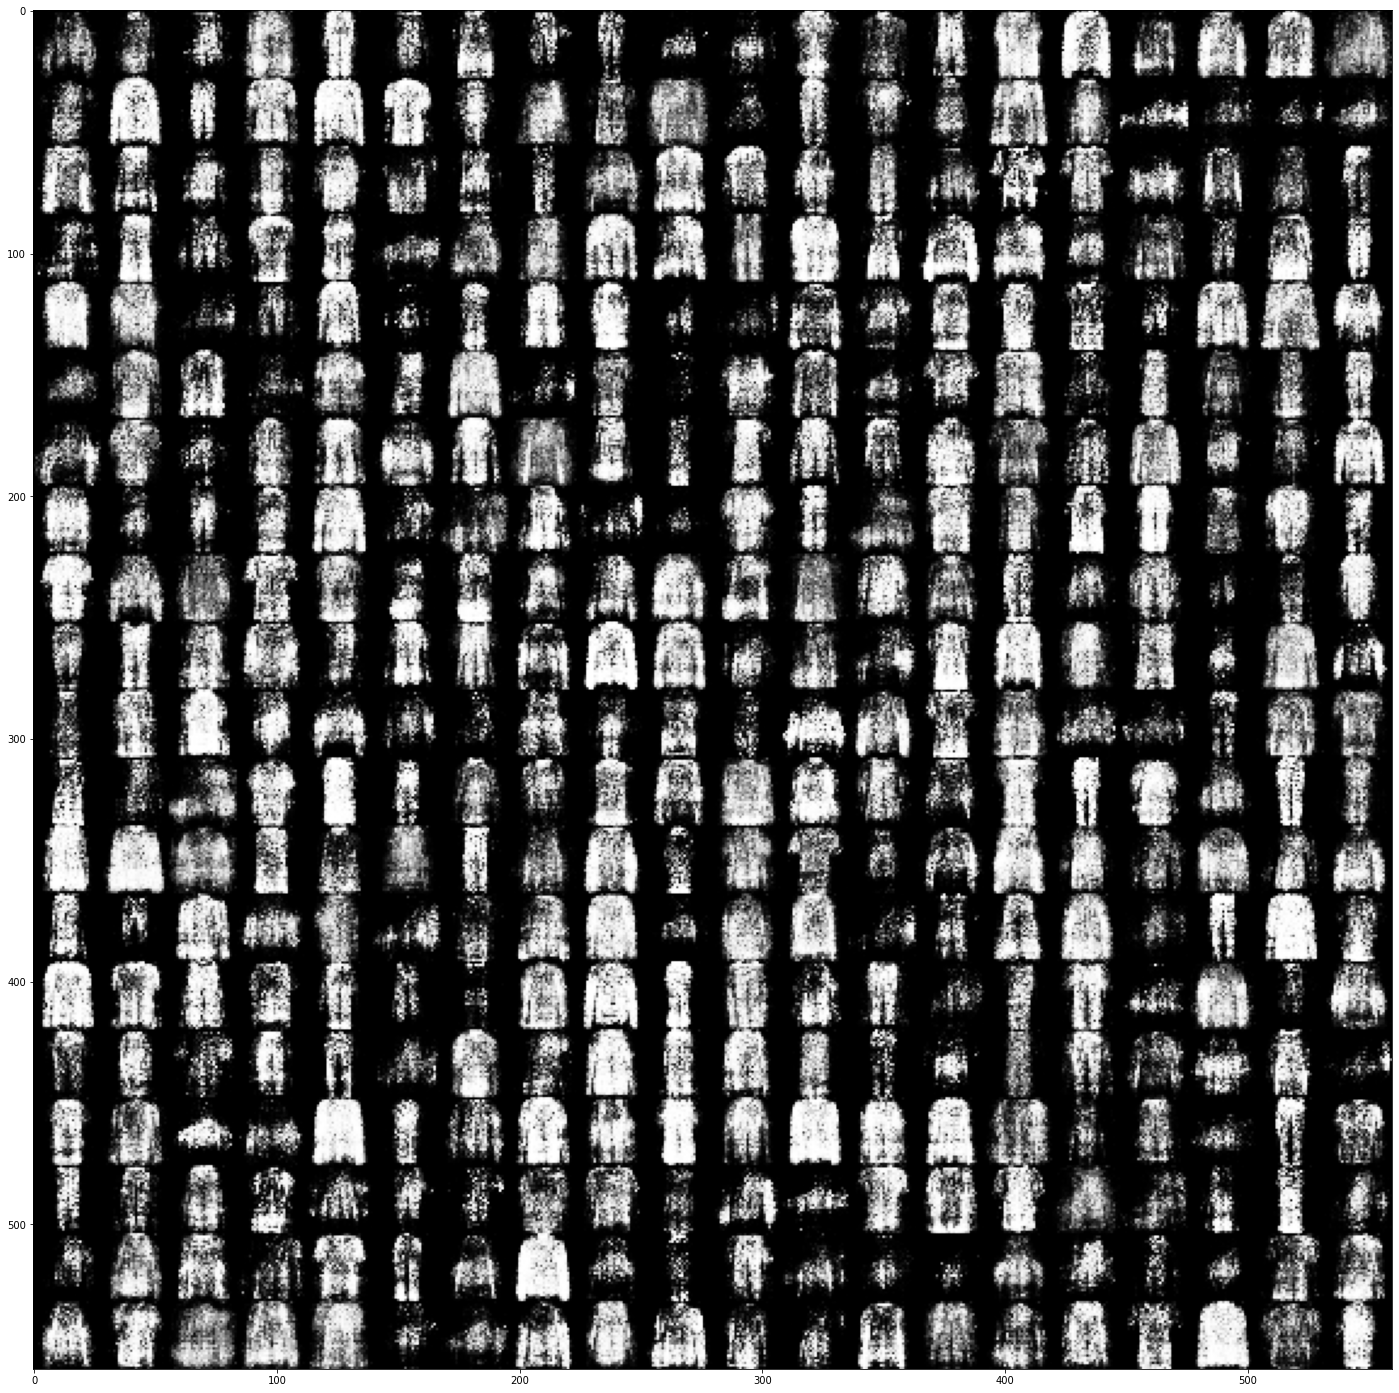

In [7]:
def plot_generated(x=20,y=20):
  import matplotlib.pyplot as plt
  imgs = model.decoder(np.random.uniform(-1,1,size=(x*y,Z_SHAPE)))
  imgs = imgs.numpy()
  figure = np.zeros(shape=(x*IMG_DIM,y*IMG_DIM),dtype=np.float32)
  for i in range(x):
    for j in range(y):
      figure[i*IMG_DIM:(i+1)*IMG_DIM,j*IMG_DIM:(j+1)*IMG_DIM] = imgs[i*y+j]
  
  plt.figure(figsize=(25,25))
  plt.imshow(figure,cmap="Greys_r")

plot_generated()